# Car auction price estimation

## Introduction

This notebook describes an estimation of car auction bid prices for auctions on the car dealer site KVD https://www.kvd.se/auktion/personbil

Auction data is extracted from the KVD site using the GitHub project at https://github.com/fredriksoderberg/auction-analysis/tree/master/auction_data  

### Data cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import preprocessing
#from sklearn.metrics import mean_squared_error
%matplotlib inline

In [37]:
data = pd.read_csv('kvd_20160711.csv', index_col = 0, low_memory=False)

Extract data subset (highest bid, estimated action price) 

In [3]:
datasubset = data[['highest_bid', 'estimated_auction_price']]

Remove non digits from price data.

In [4]:
datasubset = datasubset.replace(to_replace=r'[a-z.]|[A-Z]| ', value=r'', regex=True)

Remove rows with empty data.

In [5]:
datasubset = datasubset[datasubset.estimated_auction_price != '']
datasubset = datasubset[datasubset.highest_bid.notnull()]

Extraction of estimated auction price ranges.

In [6]:
datasubset['est_auction_price_low'] = datasubset['estimated_auction_price'].str.split('-').str[0]
datasubset['est_auction_price_high'] = datasubset['estimated_auction_price'].str.split('-').str[1]

Cast to integer datatype 

In [7]:
datasubset['highest_bid'] = datasubset['highest_bid'].astype(int)
datasubset['est_auction_price_low'] = datasubset['est_auction_price_low'].astype(int)
datasubset['est_auction_price_high'] = datasubset['est_auction_price_high'].astype(int)

### Accuracy of estimated auction prices

Calculate average estimated auction prices

In [8]:
datasubset['avg_est_auction_price'] = datasubset[['est_auction_price_low', 'est_auction_price_high']].mean(axis=1)

Calculate average deviation from (avg) estimated auction price. Get the mean over all auctions.

In [9]:
datasubset['est_auction_price_error'] = \
datasubset['highest_bid'].sub(datasubset['avg_est_auction_price'], axis=0).div(datasubset['avg_est_auction_price'], axis=0).abs()
datasubset['est_auction_price_error'].mean()

0.088238352574416035

Plot

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


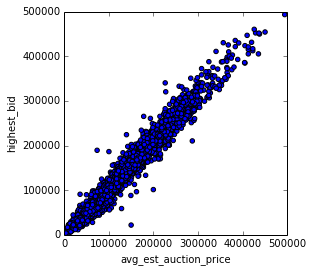

In [10]:
ax = datasubset.plot(kind='scatter', x='avg_est_auction_price', y='highest_bid', figsize=(4,4))
ax.set_xlim(0, 500000)
ax.set_ylim(0, 500000);

Calculate percentage of auction prices within the estimated range

In [11]:
nr_within_range = len(datasubset[(datasubset['highest_bid'] > datasubset['est_auction_price_low']) &  \
                             (datasubset['highest_bid'] < datasubset['est_auction_price_high'])])
total_nr_of_auctions = len(datasubset)
nr_within_range / total_nr_of_auctions

0

### Data exploration

Top 10 auction winners

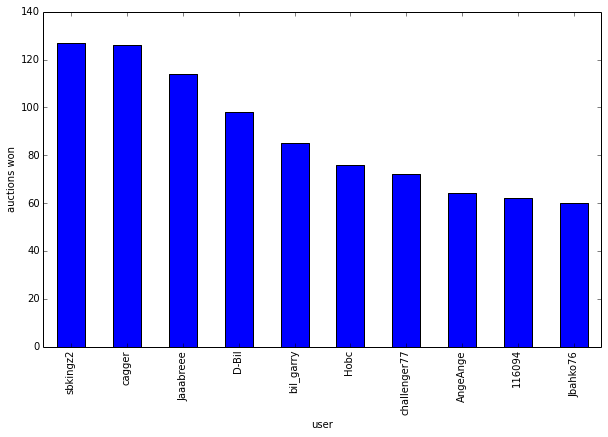

In [12]:
datasubset['bidder'] = data['bidder']
nr_of_bids_by_bidder = datasubset.groupby(['bidder']).size() 
nr_of_bids_by_bidder = nr_of_bids_by_bidder[nr_of_bids_by_bidder.ix[:,] > 5] 
nr_of_bids_by_bidder.sort_values(ascending=False, inplace=True)
nr_of_bids_by_bidder = nr_of_bids_by_bidder.head(10)
ax = nr_of_bids_by_bidder.plot(kind='bar', figsize=(10,6))
ax.set_ylabel('auctions won')
ax.set_xlabel('user');

Auctions by place of sale

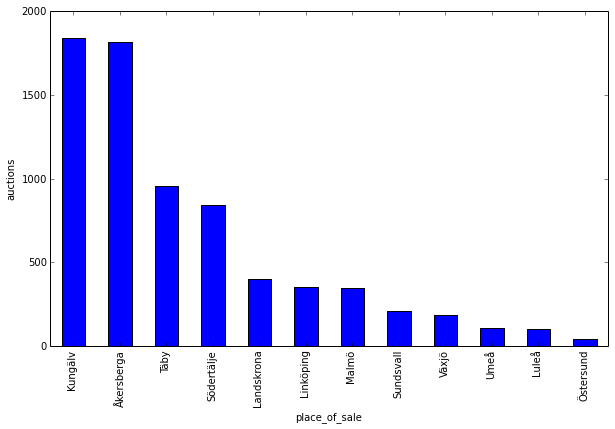

In [13]:
datasubset['place_of_sale'] = data['place_of_sale']
auctions_by_place_of_sale = datasubset.groupby(['place_of_sale']).size()
auctions_by_place_of_sale.sort_values(ascending = False, inplace=True)
ax = auctions_by_place_of_sale.plot(kind='bar', figsize=(10,6))
ax.set_ylabel('auctions');

Most active auction weekdays 

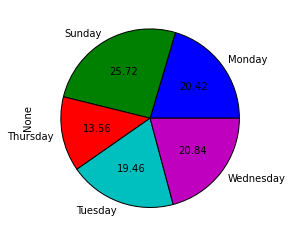

In [14]:
datasubset['auction_date'] = pd.to_datetime(data['auction_date'], errors='coerce')
datasubset['auction_weekday'] = datasubset['auction_date'].dt.dayofweek
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
datasubset['auction_weekday'].replace(days, inplace=True)
auction_date_weekday = datasubset.groupby(['auction_weekday']).size()
auction_date_weekday =  auction_date_weekday / len(datasubset)
auction_date_weekday.plot.pie(figsize=(4,4), autopct='%.2f');

Most popular car models

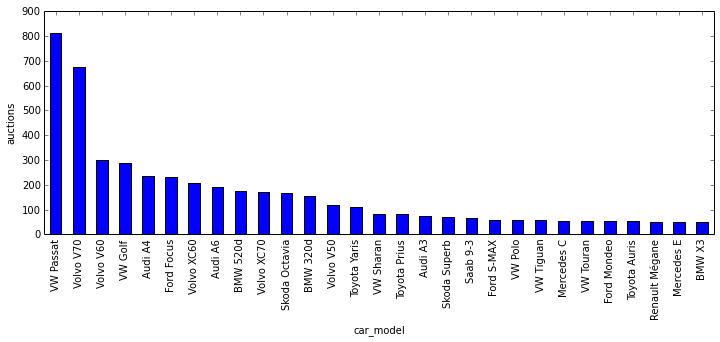

In [15]:
datasubset['car_model'] = data['car_model']
car_model_count = datasubset.groupby(['car_model']).size()
car_model_count = car_model_count[car_model_count.ix[:,] > 50]
car_model_count.sort_values(ascending=False, inplace=True)
ax = car_model_count.plot(kind='bar', figsize=(12,4))
ax.set_ylabel('auctions');

Histogram of highest bid per model year for car model "VW Passat" 

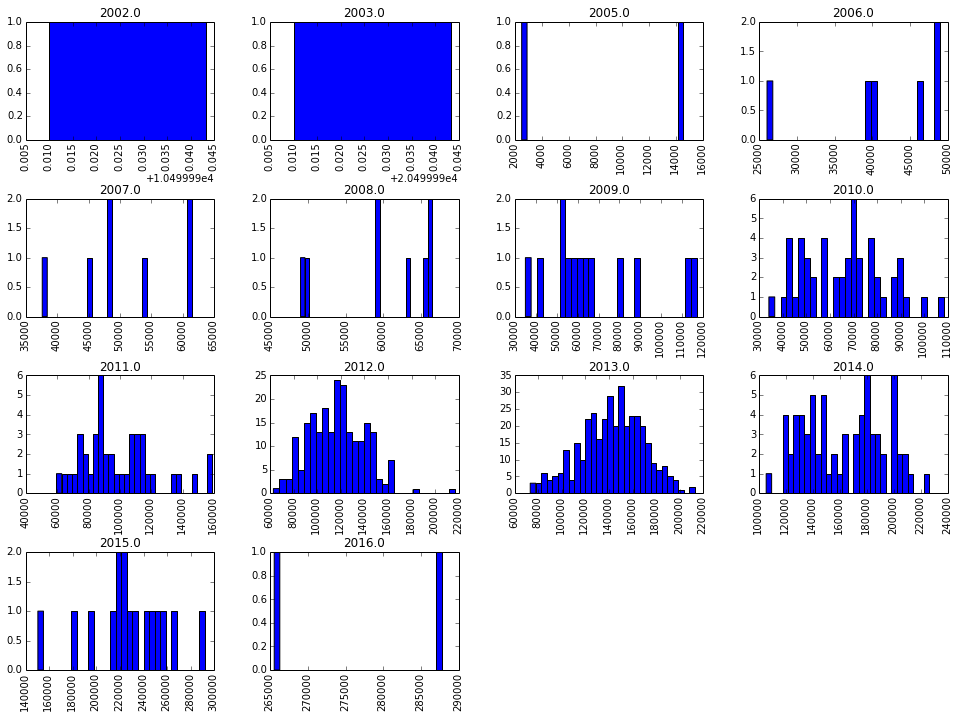

In [16]:
datasubset['model_year'] = data['model_year']
auctions_passat = datasubset[(datasubset['car_model'] == 'VW Passat')]
auctions_passat['highest_bid'].hist(by=auctions_passat['model_year'], figsize=(16,12), bins=30);

Highest bid by milage for model "VW Passat" and model year 2013 (also showing regression line)

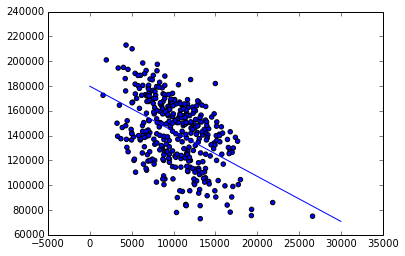

In [17]:
datasubset['milage'] = data['milage']
datasubset['milage'].replace(to_replace=r'[a-z.]|[A-Z]| ', value=r'', regex=True, inplace=True)
datasubset['milage'] = datasubset['milage'].astype(int)
auctions_passat_2013 = datasubset[(datasubset['model_year'] == 2013) & (datasubset['car_model'] == 'VW Passat')]
x = auctions_passat_2013['milage']
y = auctions_passat_2013['highest_bid']
plt.scatter(x, y)
axes = plt.gca()
m, b = np.polyfit(x, y, 1)
X_plot = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
plt.plot(X_plot, m*X_plot + b, '-');

Bid price distribution on car color

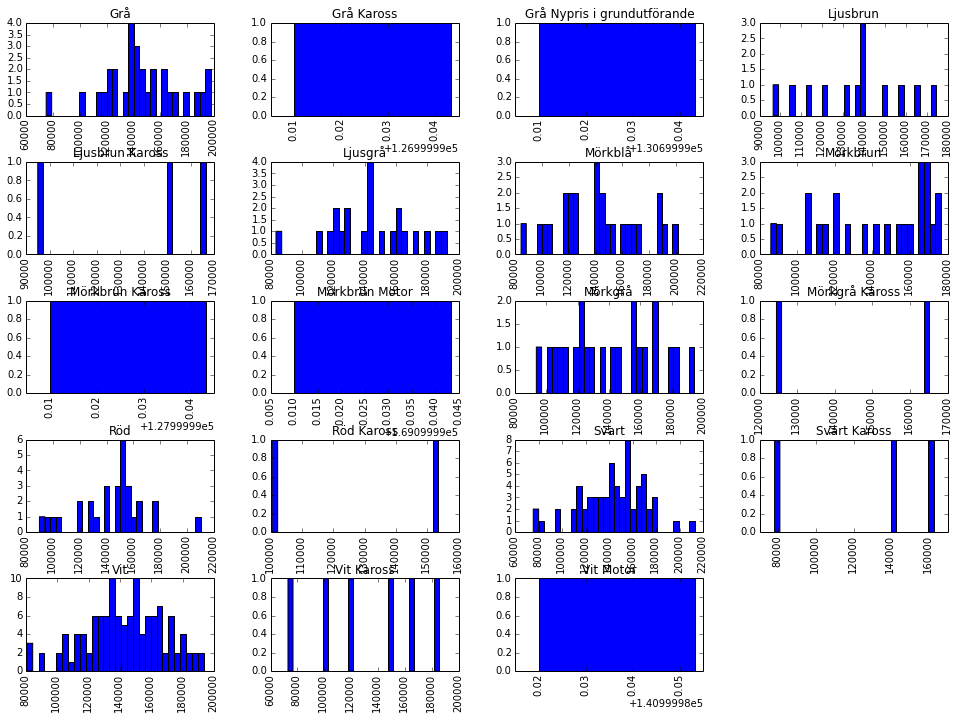

In [18]:
datasubset['color'] = data['color']
auctions_passat_color = datasubset[(datasubset['model_year'] == 2013) & (datasubset['car_model'] == 'VW Passat')]
auctions_passat_color['highest_bid'].hist(by=auctions_passat_color['color'], figsize=(16, 12), bins=30);

Average bid prices per sales location

In [19]:
auctions_passat['highest_bid'].groupby(auctions_passat['place_of_sale']).mean()

place_of_sale
Kungälv       120041
Landskrona    127649
Linköping     126902
Luleå         124568
Malmö         107998
Sundsvall     139139
Södertälje    129539
Täby          135237
Umeå          137650
Växjö         101483
Åkersberga    135641
Östersund     110320
Name: highest_bid, dtype: int64

### Price estimation

Estimation of highest bid using one boosted decision tree regressor and comparison of predictions to car auction site estimated price 

Get features

In [83]:
X = datasubset[['car_model', 'model_year', 'milage']]
X[['fuel_type', 'transmission']] = data[['fuel_type', 'transmission']]
Y = datasubset[['highest_bid']]

Preprocess string data to numeric values

In [84]:
le_model = preprocessing.LabelEncoder()
le_model.fit(X.car_model)
X.loc[:,'car_model'] = le_model.transform(X.car_model)
le_transmission = preprocessing.LabelEncoder()
le_transmission.fit(X.transmission)
X.loc[:,'transmission'] = le_transmission.transform(X.transmission)
le_fuel = preprocessing.LabelEncoder()
le_fuel.fit(X.fuel_type)
X.loc[:,'fuel_type'] = le_fuel.transform(X.fuel_type)

Create training and testing data sets

In [85]:
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(X, Y, test_size=0.33, random_state=0)

Train using ADA boost regressor

In [86]:
rng = np.random.RandomState(1)
regressor_boost = AdaBoostRegressor(DecisionTreeRegressor(max_depth=500), n_estimators=300, random_state=rng)
regressor_boost.fit(X_train, Y_train.ix[:,'highest_bid'])

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=500, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=300,
         random_state=<mtrand.RandomState object at 0x111f35f50>)

Mean squared error on training set

In [87]:
np.mean((Y_train.highest_bid - regressor_boost.predict(X_train))**2)

6409248.5076572848

Mean squared error on test set

In [88]:
np.mean((Y_test.highest_bid - regressor_boost.predict(X_test))**2)

1946026587.202436

Plotting residuals

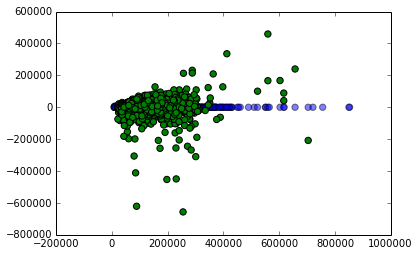

In [89]:
plt.scatter(regressor_boost.predict(X_train), regressor_boost.predict(X_train) - Y_train.highest_bid, c='b', s=40, alpha=0.5)
plt.scatter(regressor_boost.predict(X_test), regressor_boost.predict(X_test) - Y_test.highest_bid, c='g', s=40)

Plotting predictions and target values

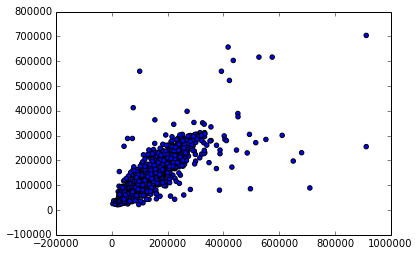

In [90]:
plt.scatter(Y_test.highest_bid, regressor_boost.predict(X_test), c='b')

Add predictions to data set

In [91]:
X_test.loc[:,'pred_price'] = regressor_boost.predict(X_test)

Transform back to car model descriptions

In [92]:
X_test.loc[:,'car_model'] = le_model.inverse_transform(X_test.car_model)
X_test.loc[:,'fuel_type'] = le_fuel.inverse_transform(X_test.fuel_type)
X_test.loc[:,'transmission'] = le_transmission.inverse_transform(X_test.transmission)

Example data set with predicted value

In [107]:
X_example = pd.DataFrame({'car_model' : 'Ford S-MAX', 'model_year' : 2014, 'milage' : 5000, \
                          'fuel_type' : 'Diesel', 'transmission' : 'Manuell'}, index=[0])
X_example = X_example[['car_model', 'model_year', 'milage', 'fuel_type', 'transmission']]
X_example.loc[:,'car_model'] = le_model.transform(X_example.car_model)
X_example.loc[:,'fuel_type'] = le_fuel.transform(X_example.fuel_type)
X_example.loc[:,'transmission'] = le_transmission.transform(X_example.transmission)
regressor_boost.predict(X_example)

array([ 190500.])

Add average estimated auction price (by auction site) and highest bid to dataset 

In [108]:
X_test.loc[:,'avg_est_auction_price'] = datasubset[['avg_est_auction_price']]
X_test.loc[:,'highest_price'] = Y_test.highest_bid

Mean squared error from prediction by ADA boosted regressor

In [109]:
np.mean((X_test['highest_price'] - X_test['pred_price'])**2)

1946026587.202436

Mean squared error from prediction by car auction site

In [110]:
np.mean((X_test['highest_price'] - X_test['avg_est_auction_price'])**2)

218684901.14804703